# Implémentez un modèle de scoring

2023/08/02 14:26:25 INFO mlflow.tracking.fluent: Experiment with name 'RandomF Models' does not exist. Creating a new experiment.


Best params:
 {'max_depth': 9, 'min_samples_split': 11, 'n_estimators': 50}
Model score: 0.359
Time: 41.0
balanced_accuracy: 0.505
f1: 0.019801980198019802
precision: 1.0
recall: 0.01
roc_auc: 0.505


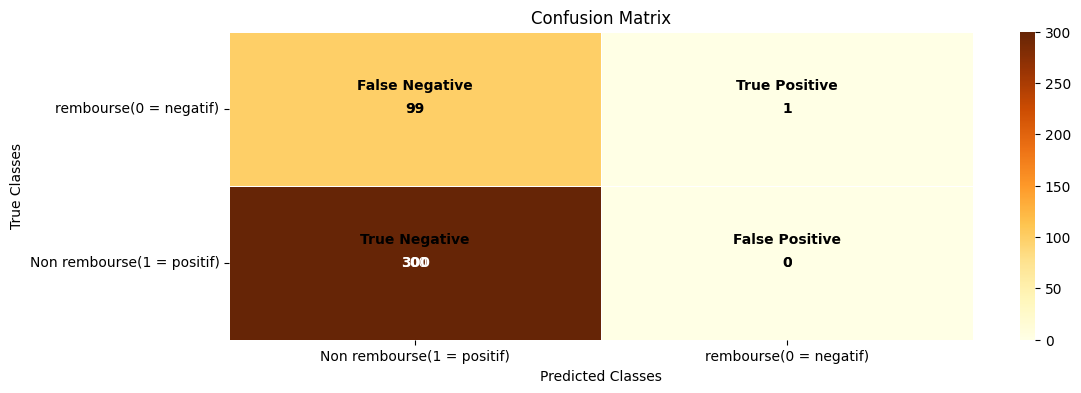

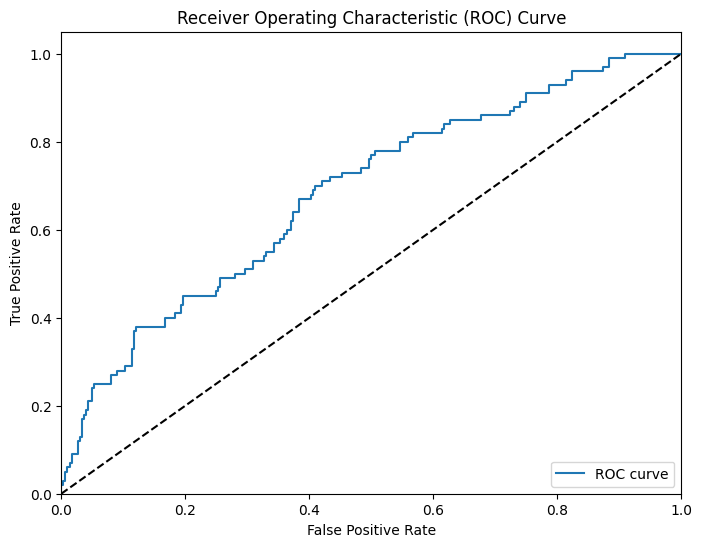

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/08/02 14:27:16 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 30
Created version '30' of model 'CreditModels'.


In [53]:
# Imbalanced data
model_metrics_dict['RF_imbalance'] = rf_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 {'max_depth': 9, 'min_samples_split': 10, 'n_estimators': 50}
Model score: 0.504
Time: 61.0
balanced_accuracy: 0.5933333333333333
f1: 0.3625
precision: 0.48333333333333334
recall: 0.29
roc_auc: 0.5933333333333334


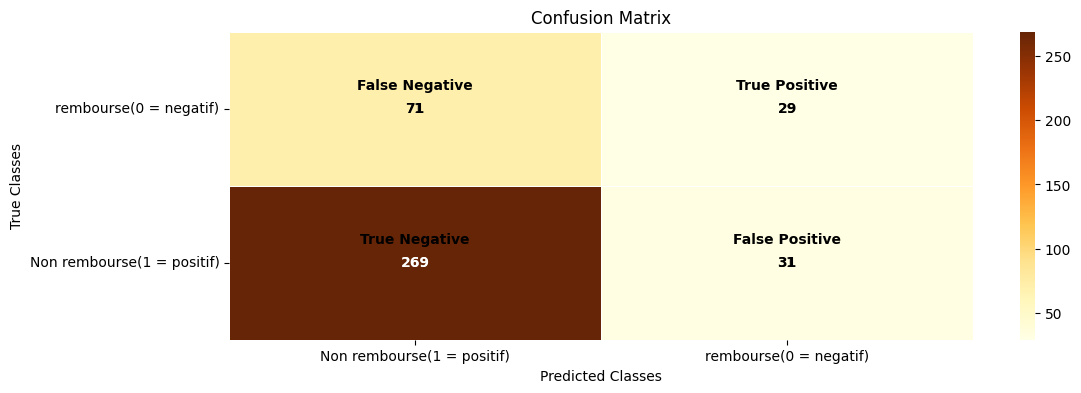

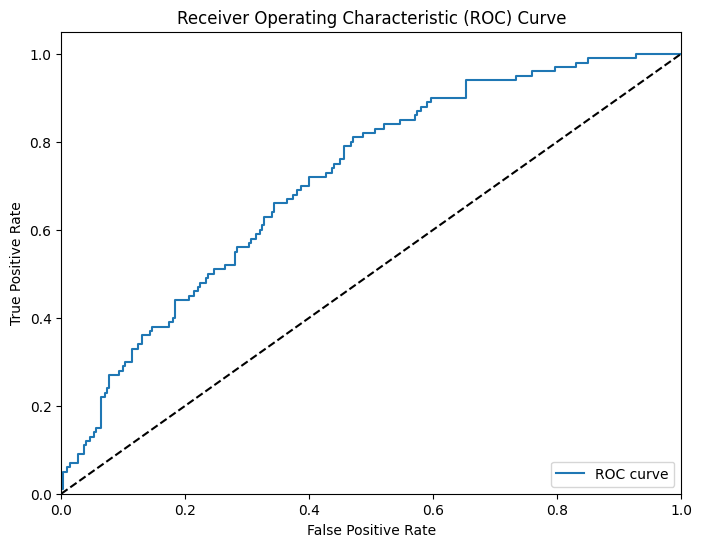

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/08/02 14:28:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 31
Created version '31' of model 'CreditModels'.


In [54]:
# Oversampling (SMOTE)
model_metrics_dict['RF_oversample'] = rf_model(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 100}
Model score: 0.641
Time: 26.0
balanced_accuracy: 0.645
f1: 0.4754716981132076
precision: 0.38181818181818183
recall: 0.63
roc_auc: 0.6449999999999999


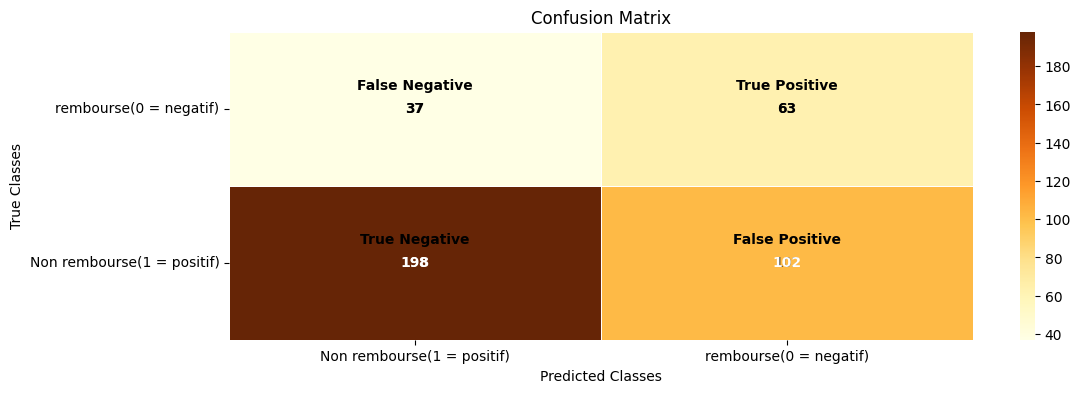

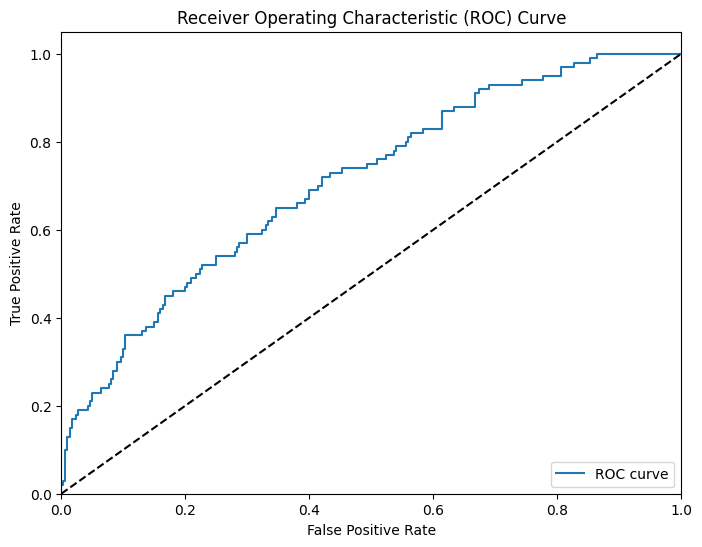

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/08/02 14:29:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 32
Created version '32' of model 'CreditModels'.


In [55]:
# Undersampling (RUS)
model_metrics_dict['RF_undersample'] = rf_model(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'max_depth': 7, 'min_samples_split': 11, 'n_estimators': 100}
Model score: 0.546
Time: 40.0
balanced_accuracy: 0.62
f1: 0.42045454545454547
precision: 0.4868421052631579
recall: 0.37
roc_auc: 0.6200000000000001


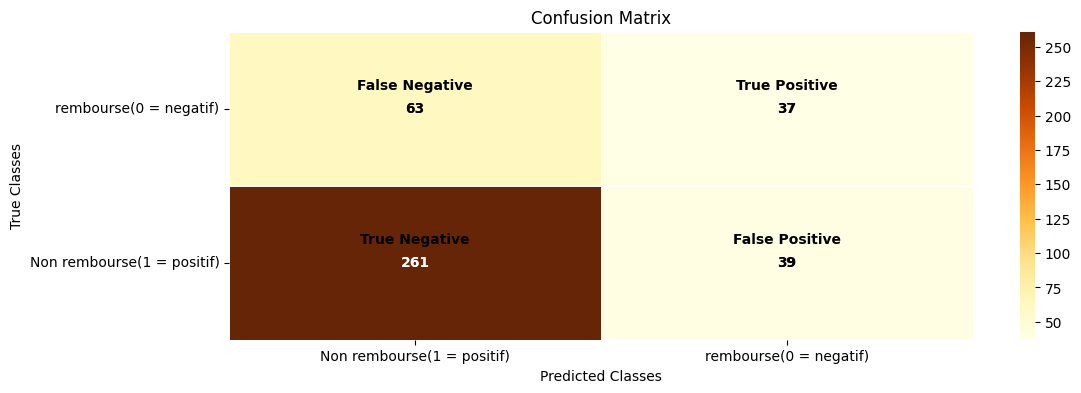

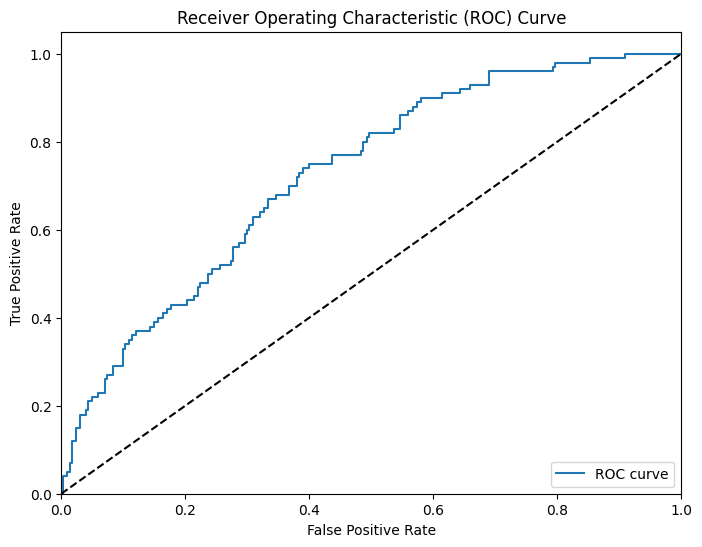

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/08/02 14:29:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 33
Created version '33' of model 'CreditModels'.


In [56]:
 # class weight (balanced)
model_metrics_dict['RT_weighted'] = rf_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)  

In [57]:
def xgb_model(X_train, X_test, y_train, y_test, use_class_weights=False):
    name = 'xgb'
    # Params for XGBClassifier
    param_grid = [{'n_estimators': [50, 100],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.05, 0.04]}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('XGBoost Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            xgb_model = XGBClassifier()
            
            # Hyperparameter tuning
            grid_xgb = GridSearchCV(estimator=xgb_model,
                                param_grid=param_grid,
                                return_train_score=True,
                                error_score='raise',
                                scoring=business_metric,
                                cv=5)
            
            # Fit the model to the training data
            if use_class_weights:
                classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
                grid_xgb.fit(X_train, y_train, sample_weight=classes_weights)
            else:
                grid_xgb.fit(X_train, y_train)
            
            # Display best params
            print("Best params:\n", grid_xgb.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid_xgb.score(X_test, y_test))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = grid_xgb.predict(X_test)
            
            # Calculate and print evaluation metrics
            metrics = eval_metrics(y_test, y_pred)
            for name, score in metrics.items():
                print(f"{name}: {score}")
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test, grid_xgb.predict_proba(X_test)[:, 1])
            
            # Store metrics into MLflow
            for name, score in metrics.items():
                mlflow.log_metric(name, score)
            
            # Store params into MLflow
            for k, v in grid_xgb.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid_xgb, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid_xgb, name)
                
            metrics['business_metric'] = round(costs(y_test, y_pred),2)
            return metrics


2023/08/02 14:29:53 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost Models' does not exist. Creating a new experiment.


Best params:
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Model score: 0.438
Time: 101.0
balanced_accuracy: 0.5583333333333333
f1: 0.24
precision: 0.6
recall: 0.15
roc_auc: 0.5583333333333332


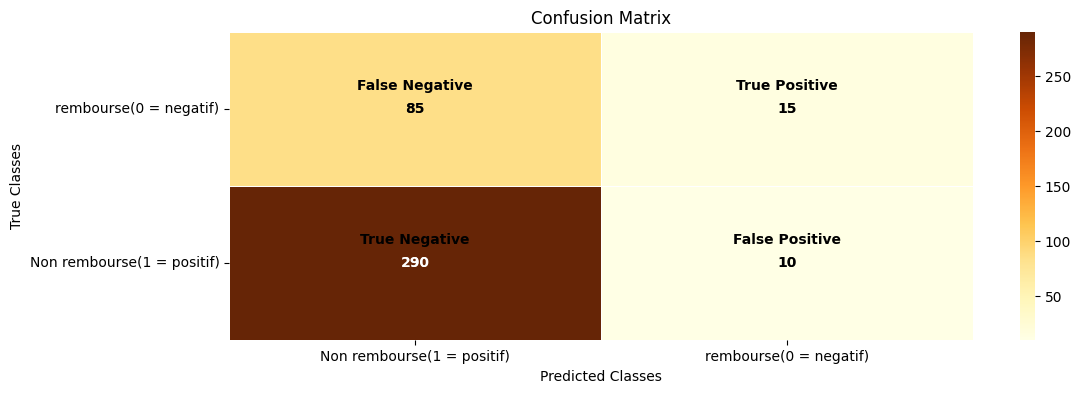

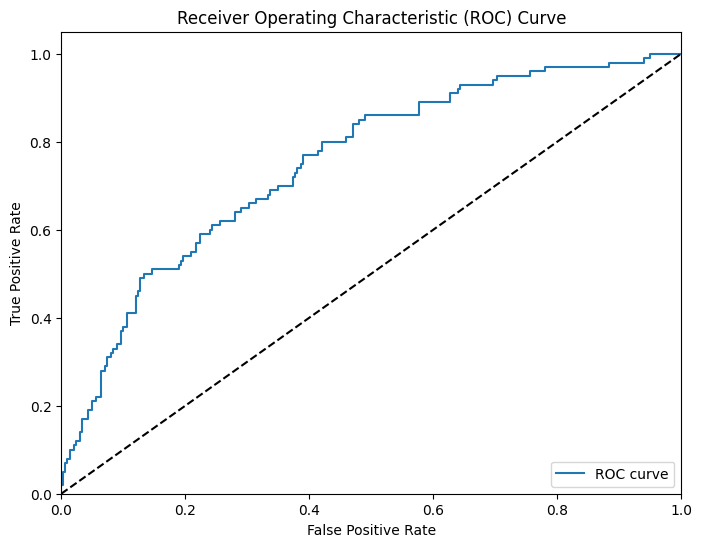

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/08/02 14:31:51 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 34
Created version '34' of model 'CreditModels'.


In [58]:
# Imbalanced data
model_metrics_dict['XGB_imbalance'] = xgb_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 {'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 100}
Model score: 0.465
Time: 117.0
balanced_accuracy: 0.5716666666666667
f1: 0.2978723404255319
precision: 0.5121951219512195
recall: 0.21
roc_auc: 0.5716666666666667


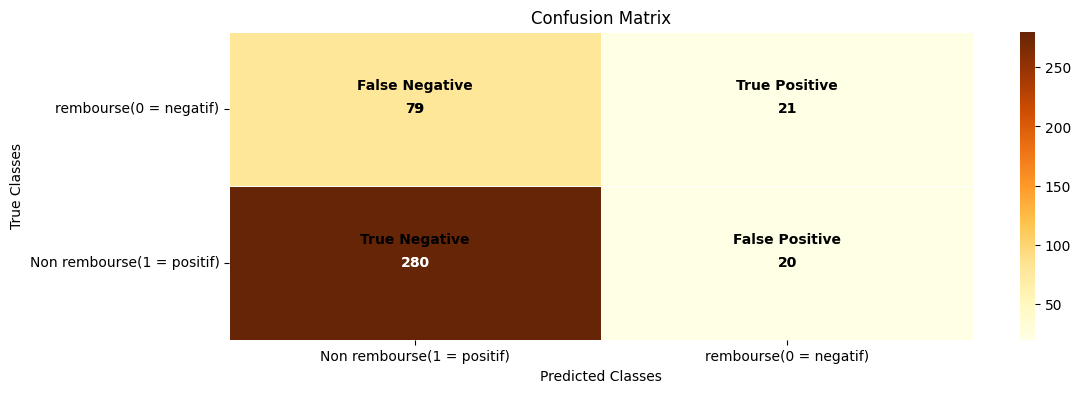

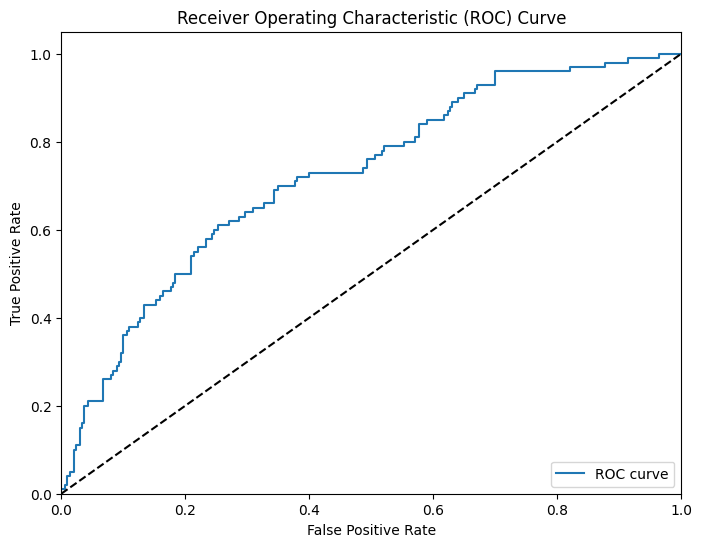

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/08/02 14:33:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 35
Created version '35' of model 'CreditModels'.


In [59]:
# Oversampling (SMOTE)
model_metrics_dict['XGB_oversample'] = xgb_model(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 100}
Model score: 0.674
Time: 59.0
balanced_accuracy: 0.675
f1: 0.5095057034220534
precision: 0.4110429447852761
recall: 0.67
roc_auc: 0.6749999999999999


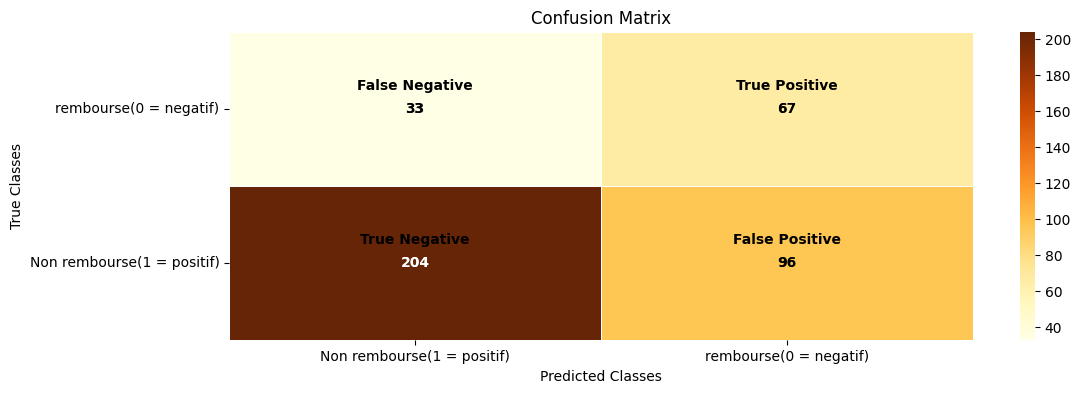

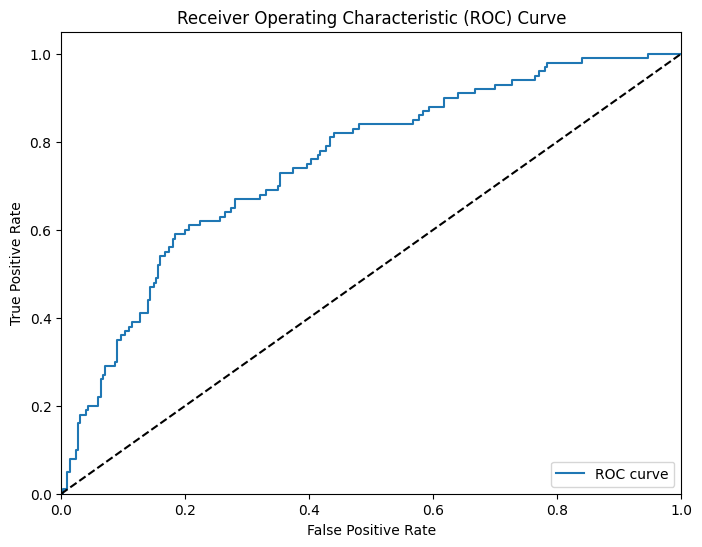

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/08/02 14:35:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 36
Created version '36' of model 'CreditModels'.


In [60]:
# Undersampling (RUS)
model_metrics_dict['XGB_undersample'] = xgb_model(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 50}
Model score: 0.652
Time: 81.0
balanced_accuracy: 0.6699999999999999
f1: 0.5041322314049587
precision: 0.4295774647887324
recall: 0.61
roc_auc: 0.6699999999999999


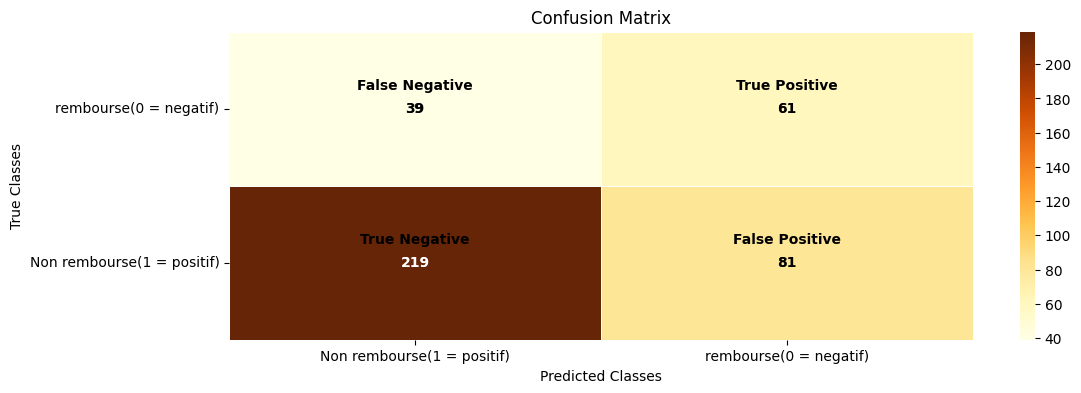

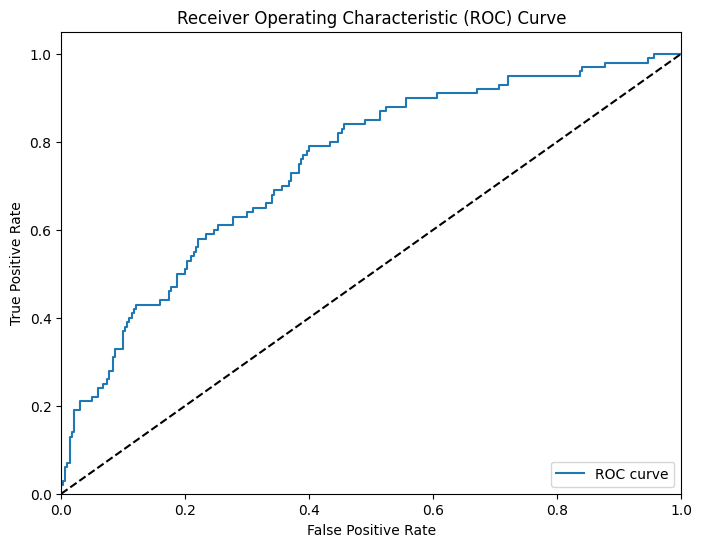

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/08/02 14:36:32 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 37
Created version '37' of model 'CreditModels'.


In [61]:
 # class weight (balanced)
model_metrics_dict['XGB_weighted'] = xgb_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)  

In [62]:
df_sample.shape

(2000, 429)

In [63]:
results = pd.DataFrame(columns=['model', 'balanced_accuracy', 'business_metric','roc_auc','precision','recall','f1'])

# Iterate over the dictionary items and append rows to the DataFrame
for model, values in model_metrics_dict.items():
    results = results.append({'model': model, 'balanced_accuracy': values['balanced_accuracy'], 'business_metric': values['business_metric'], 'roc_auc': values['roc_auc'], 'precision': values['precision'], 'recall': values['recall'], 'f1': values['f1']}, ignore_index=True)
results = results.sort_values(by=['business_metric','roc_auc'],ascending=False)
results

,model,balanced_accuracy,business_metric,roc_auc,precision,recall,f1
21,XGB_undersample,0.675000,0.67,0.675000,0.411043,0.67,0.509506
14,DT_weighted,0.661667,0.67,0.661667,0.385475,0.69,0.494624
22,XGB_weighted,0.670000,0.65,0.670000,0.429577,0.61,0.504132
17,RF_undersample,0.645000,0.64,0.645000,0.381818,0.63,0.475472
9,KNN_undersample,0.611667,0.63,0.611667,0.330144,0.69,0.446602
13,DT_undersample,0.570000,0.57,0.570000,0.307692,0.56,0.397163
4,LR_oversample,0.586667,0.56,0.586667,0.340278,0.49,0.401639
6,LR_weighted,0.583333,0.56,0.583333,0.333333,0.50,0.400000
8,KNN_oversample,0.531667,0.56,0.531667,0.270042,0.64,0.379822
18,RT_weighted,0.620000,0.55,0.620000,0.486842,0.37,0.420455


# Split classique

In [64]:
df_final_without_ID = pd.read_csv(os.path.join('..','data','df_final.csv'))
df_final_without_ID.sample(5)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
232923,0.0,Cash loans,1,0,0,2,72000.0,198666.0,15696.0,175500.0,...,11559.575250,693574.515,3.915,90001.665,12714.759750,762885.585,-48.0,-1323.283333,-79397.0,60.0
263698,0.0,Cash loans,1,0,1,0,221400.0,247500.0,9814.5,247500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36463,0.0,Cash loans,0,0,1,0,360000.0,521136.0,54855.0,495000.0,...,4623.738750,55484.865,0.180,4630.680,3851.958750,46223.505,-752.0,-893.416667,-10721.0,12.0
279380,0.0,Cash loans,0,1,0,0,360000.0,824917.5,39816.0,724500.0,...,44156.157353,1501309.350,1116.180,45455.265,42819.237794,1455854.085,-4.0,-460.147059,-15645.0,34.0
148324,0.0,Cash loans,1,0,0,0,135000.0,628114.5,22689.0,477000.0,...,11926.170000,143114.040,11795.985,11938.005,11926.170000,143114.040,-1465.0,-1634.166667,-19610.0,12.0


In [65]:
df_final_without_ID.shape

(307507, 429)

In [66]:
X = df_final_without_ID.drop('TARGET',axis=1)
y = df_final_without_ID['TARGET']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8)

In [68]:
X_train.shape,X_test.shape

((246005, 428), (61502, 428))

In [69]:
del df_final_without_ID

In [70]:
categorical_list_2 = []
numerical_list_2 = []

# Identify categorical and numerical columns
for i in X_train.columns.tolist():
    if X_train[i].dtype == 'object':
        categorical_list_2.append(i)
    else:
        numerical_list_2.append(i)

# Create and fit SimpleImputer on numerical columns
simple_imputer = SimpleImputer(strategy='median').fit(X_train[numerical_list_2])

# Infer signature for the imputer model
signature = infer_signature(X_train, y_train)

# Save the imputer model using MLflow
mlflow.sklearn.save_model(simple_imputer, 'imputer', signature=signature)

2023/08/02 14:39:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


# Modèle final

In [71]:
def model_xgb_final(X_train_, X_test_, y_train_, y_test_, use_class_weights=False):
    name = 'xgb_final'
    # Params for XGBClassifier
    param_grid = [{'n_estimators': [50, 100],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.05, 0.04]}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('XGBoost Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            cls = XGBClassifier()
            
            # Hyperparameter tuning
            grid = GridSearchCV(estimator=cls,
                                param_grid=param_grid,
                                return_train_score=True,
                                error_score='raise',
                                scoring=business_metric,
                                cv=5)
            
            # Fit the model to the training data
            if use_class_weights:
                classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_)
                grid.fit(X_train_, y_train_, sample_weight=classes_weights)
            else:
                grid.fit(X_train_, y_train_)
            
            # Display best params
            print("Best params:\n", grid.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid.score(X_test_, y_test_))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = grid.predict(X_test_)
            
            # Calculate and print evaluation metrics
            eval_metrics(y_test_, y_pred)
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test_, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test_, grid.predict_proba(X_test_)[:, 1])
            
            # Store metrics into MLflow
            metrics = eval_metrics(y_test_, y_pred)
            for k, v in metrics.items():
                mlflow.log_metric(k, v)
            
            # Store params into MLflow
            for k, v in grid.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid, name)
            return grid.best_params_

Best params:
 {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 50}
Model score: 0.652
Time: 109.0
balanced_accuracy: 0.6699999999999999
f1: 0.5041322314049587
precision: 0.4295774647887324
recall: 0.61
roc_auc: 0.6699999999999999


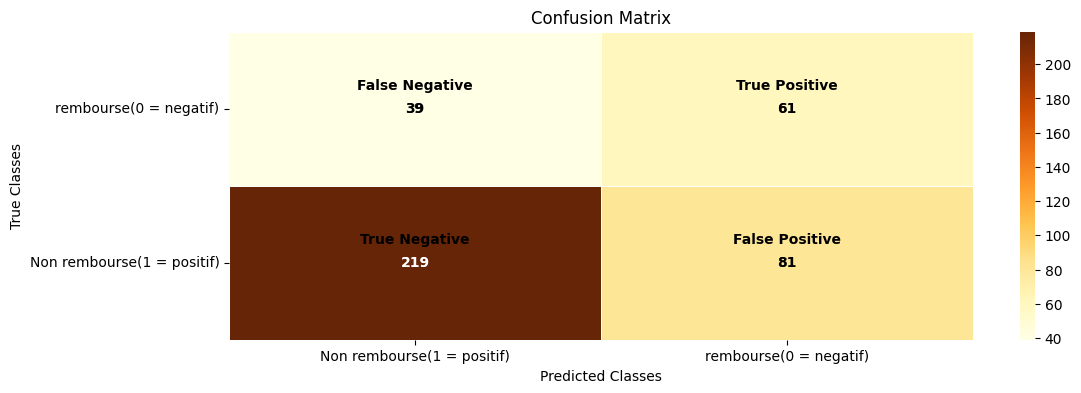

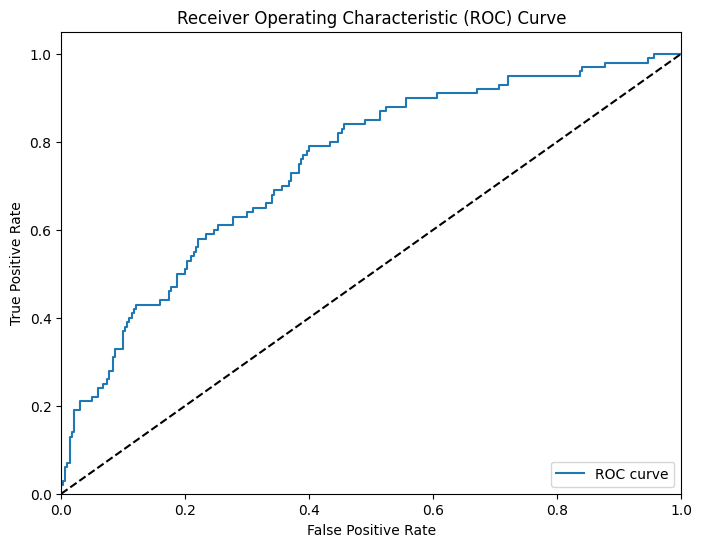

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/08/02 14:41:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 38
Created version '38' of model 'CreditModels'.


In [72]:
 # class weight (balanced)
best_params = xgb_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)  

In [73]:
best_params

{'balanced_accuracy': 0.6699999999999999,
 'f1': 0.5041322314049587,
 'precision': 0.4295774647887324,
 'recall': 0.61,
 'roc_auc': 0.6699999999999999,
 'business_metric': 0.65}

# Préparation au déploiement

In [74]:
pipeline = Pipeline([('preprocessor', preprocessor), 
                     ('classifier', XGBClassifier(**best_params))])

In [75]:
# pipeline.fit(X_train_prepro,y_train_sample)
pipeline.fit(X_train,y_train)

[14:42:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "balanced_accuracy", "business_metric", "f1", "precision", "recall", "roc_auc" } are not used.



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELA

In [76]:
pipeline.predict(df_sample.drop(columns=['TARGET']))

array([0, 0, 0, ..., 1, 0, 0])

In [77]:
sample_data_file_path = os.path.join('..','data','sample_data.pkl')
data_to_export = df_sample.drop(columns=['TARGET'])
outfile = open(sample_data_file_path,'wb')
pickle.dump(data_to_export,outfile)
outfile.close()

In [78]:
model_file_path = os.path.join('..','data','model.pkl')
outfile = open(model_file_path,'wb')
pickle.dump(pipeline,outfile)
outfile.close()

# Définition du seuil

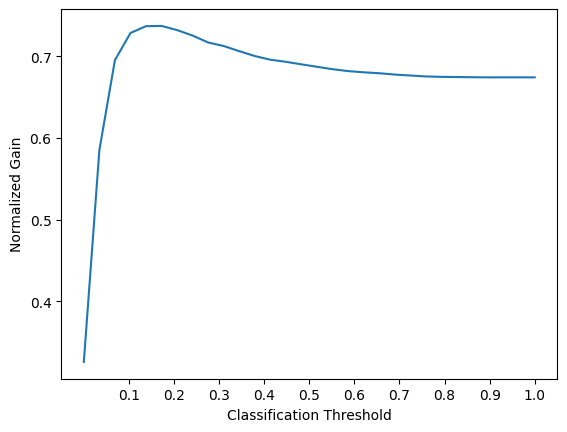

In [79]:
threshold_x = np.linspace(0.0, 1, 30)
cost_function = []

for threshold in threshold_x:
    # Calculate y_pred based on threshold
    y_scores = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > threshold).astype(int)
    
    # Calculate the custom_metric score
    cost_function.append(costs(y_test, y_pred))

# Plot the normalized gain
plt.plot(threshold_x, cost_function)
plt.xlabel("Classification Threshold")
plt.ylabel("Normalized Gain")
plt.xticks(np.linspace(0.1, 1, 10))
plt.show()

In [80]:
threshold = []
for thresh, cost in zip(threshold_x, cost_function):
    if cost == max(cost_function):
        threshold.append(thresh)

# Modify predictions using manual threshold adjustment
y_pred = pipeline.predict_proba(X_test)
y_pred = (y_pred[:, 1] >= threshold) * 1
threshold[0]

0.1724137931034483

In [81]:
name = 'xgb_threshold/' + str(threshold[0])

# Set the path where it is stored
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set the name of the experiment folder
mlflow.set_experiment('XGBoost Models')

# Initialise counting time
time1 = time.time()

# Executed as a script
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(42)
    # Give the run a name
    with mlflow.start_run(run_name=name) as run:
        
        # Return all metrics
        print('Scores après application du threshold :')
        for k, v in zip(eval_metrics(y_test, y_pred).keys(), eval_metrics(y_test, y_pred).values()):
            print('{} : {:.3f}'.format(k, v))
        print("score custom metric : %.3f" % costs(y_test, y_pred))
        
        time2 = np.round(time.time() - time1, 0)


Scores après application du threshold :
balanced_accuracy : 0.646
f1 : 0.316
precision : 0.268
recall : 0.385
roc_auc : 0.646
score custom metric : 0.737


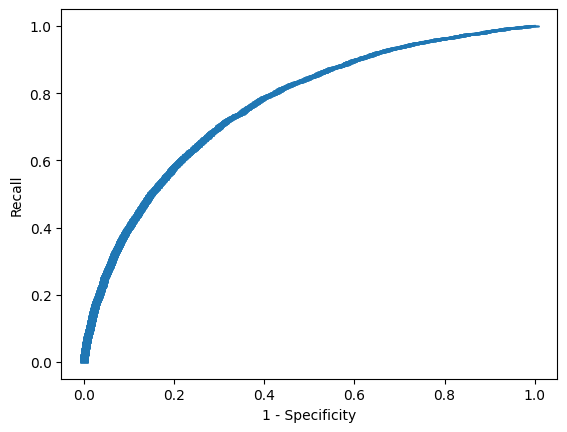

In [82]:
[fpr, tpr, thr] = roc_curve(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:, 1])

# ROC curve
plt.plot(fpr, tpr, marker="_")
plt.xlabel('1 - Specificity')
plt.ylabel('Recall')
plt.show()


In [83]:
# Enregistrement du modèle 
signature = infer_signature(X_train, y_train)
mlflow.sklearn.save_model(pipeline, 'MLFlow Best Model', signature=signature)

# SHAP Values

In [84]:
categorical_list_2 = []
numerical_list_2 = []
for i in X_train.columns.tolist():
    if X_train[i].dtype=='object':
        categorical_list_2.append(i)
    else:
        numerical_list_2.append(i)
        
# Récupérer le nom des catégories
cat = pipeline['preprocessor'].transformers_[1][1]\
      .get_feature_names_out(categorical_list_2)

# Enregistrer le model
classifier = pipeline.named_steps['classifier']

# Nom de l'ensemble des colonnes preprocessed
column_names = numerical_list_2+cat.tolist()

In [85]:
# Generate global Shapley Values
# Preprocess the data
df_preprocess = pd.DataFrame(pipeline.named_steps['preprocessor'].transform(X_train),
                             columns=column_names)

# Get the classifier from the pipeline
classifier = pipeline.named_steps['classifier']

# Create an explainer using the classifier and preprocessed data
explainer = shap.Explainer(classifier, df_preprocess)

# Calculate Shapley values for the preprocessed data
# Set check_additivity=False to disable additivity check
shap_values = explainer(df_preprocess, check_additivity=False)

100%|===================| 246000/246005 [21:19<00:00]        

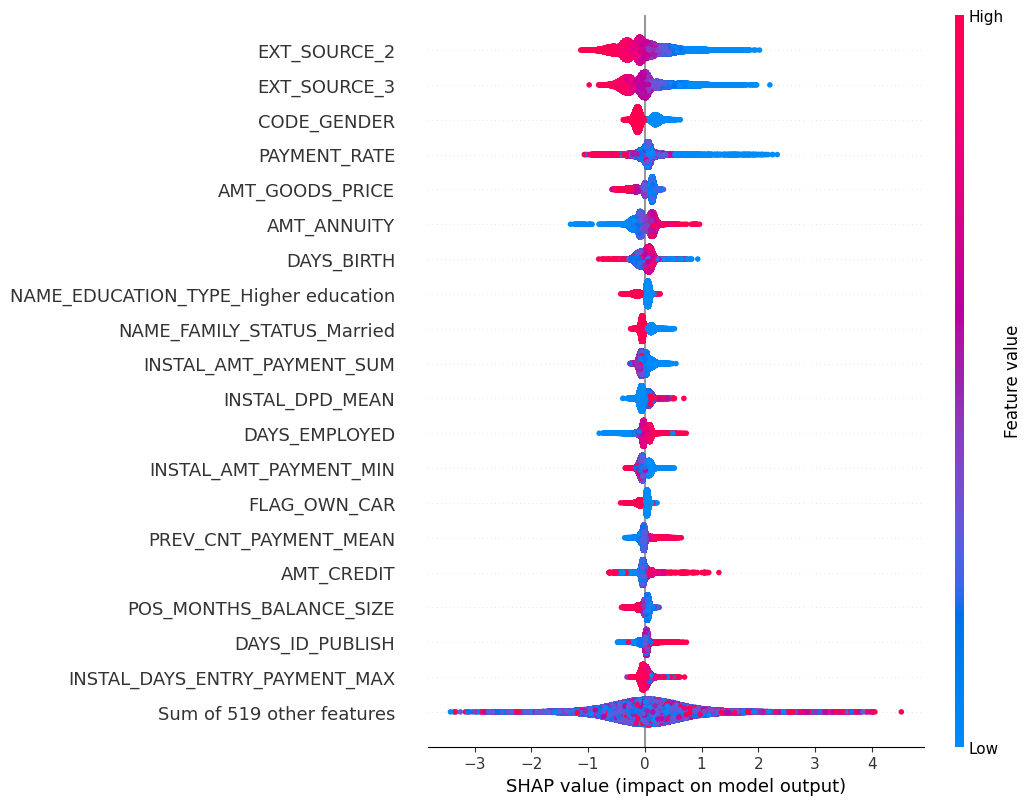

In [86]:
# Afficher interpretabilité globale
shap.plots.beeswarm(shap_values,max_display=20)

In [87]:
# Generate Shapley values for a specific client
# Get the client ID from the X_train index
client_id = X_train.index.tolist()[0]

# Create a list of all IDs in X_train
list_ID = X_train.index.tolist()

# Initialize an empty list to store the indices of the client's ID
index_ID = []

# Iterate over the list of IDs and find the indices that match the client ID
for ind, ID in enumerate(list_ID):
    if list_ID[ind] == client_id:
        index_ID.append(ind)

# Extract the Shapley values for the client using the obtained indices
shap_values_client = shap_values[index_ID][0]


In [88]:
client_id

40682

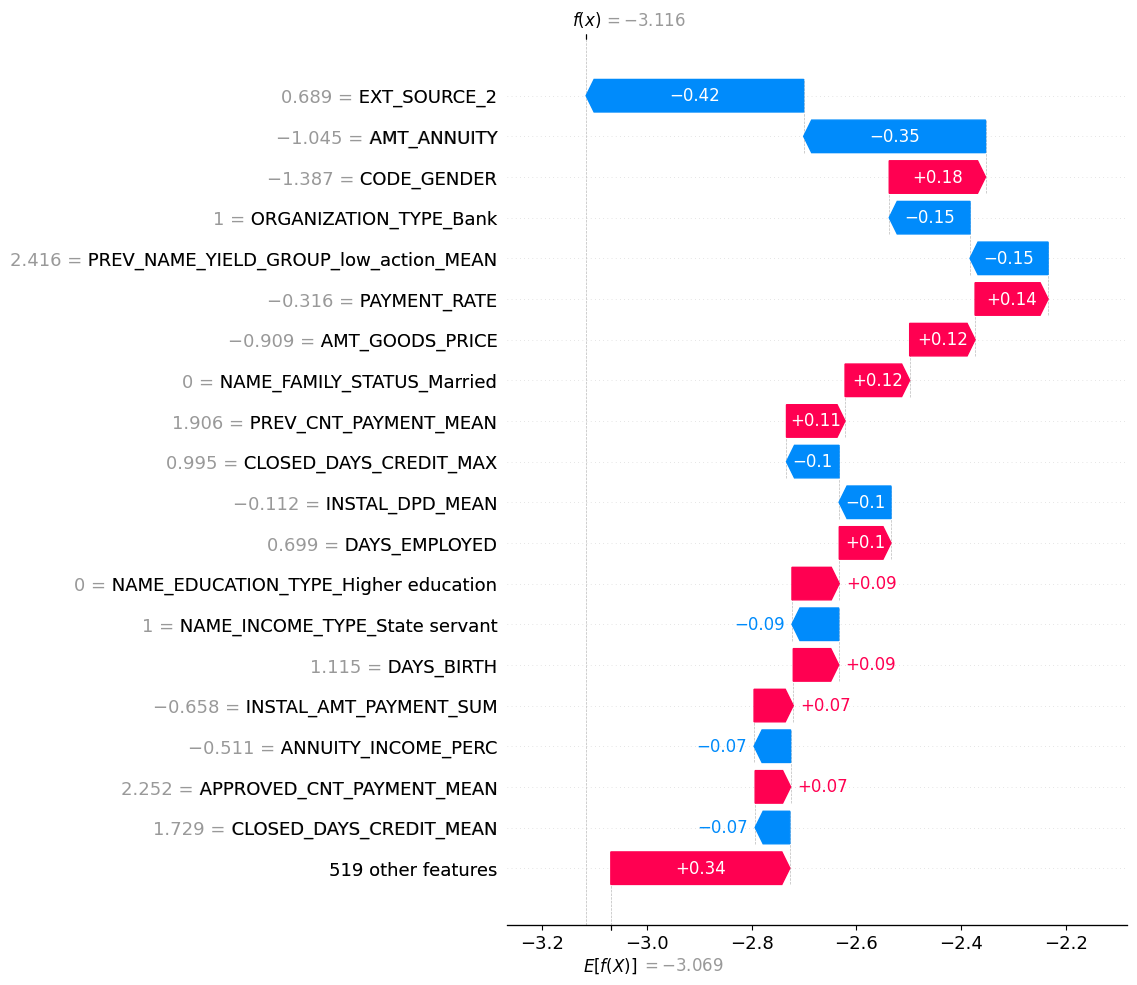

In [89]:
# Afficher interpretabilité locale
shap.plots.waterfall(shap_values_client,max_display=20)